In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to dataset files:", path)


100%|██████████| 6.70G/6.70G [02:51<00:00, 41.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2


In [ ]:
import os
import kagglehub

# Download latest version
downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to downloaded dataset files:", downloaded_path)

# Veri seti yolu: kagglehub tarafından indirilen path'i kullan
# İndirilen path'in içindeki 'Dataset - train+val+test' klasörüne işaret etmesi gerekiyor.
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Sınıf sayımlarını hesaplayan fonksiyon
def count_images_in_folder(folder_path):
    """Verilen klasördeki sınıfların görsel sayılarını hesaplar."""
    class_counts = {}
    # Check if the folder_path exists before listing
    if not os.path.exists(folder_path):
        print(f"Hata: Klasör bulunamadı: {folder_path}")
        return class_counts # Return empty if folder doesn't exist

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([name for name in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, name))])
            class_counts[class_name] = num_images
    return class_counts

# Klasörleri tara ve sınıf sayılarını yazdır
for folder in ['train', 'val', 'test']:
    folder_path = os.path.join(dataset_path, folder)
    print(f"\n'{folder}' klasöründeki içerikler:")

    class_counts = count_images_in_folder(folder_path)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} görsel")

Path to downloaded dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2

'train' klasöründeki içerikler:
  NORMAL: 35973 görsel
  DME: 8118 görsel
  DRUSEN: 6206 görsel
  CNV: 26218 görsel

'val' klasöründeki içerikler:
  NORMAL: 10278 görsel
  DME: 2319 görsel
  DRUSEN: 1773 görsel
  CNV: 7491 görsel

'test' klasöründeki içerikler:
  NORMAL: 5139 görsel
  DME: 1161 görsel
  DRUSEN: 887 görsel
  CNV: 3746 görsel


In [ ]:
# === Veri yolu ===
# dataset_path = "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test" # Remove this hardcoded path

# Use the path obtained from kagglehub.dataset_download
# downloaded_path is defined in the previous cell
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Import tensorflow
import tensorflow as tf

# === Dataset yükle ===
def load_datasets():
    train_dataset_initial = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset_initial = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset_initial = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    # Get class names before caching and prefetching
    class_names = train_dataset_initial.class_names

    train_dataset = train_dataset_initial.cache().prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset_initial.cache().prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset_initial.cache().prefetch(tf.data.AUTOTUNE)


    return train_dataset, val_dataset, test_dataset, class_names

# Call the load_datasets function and assign the returned values
train_dataset, val_dataset, test_dataset, class_names = load_datasets()

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf # Import tensorflow to access dataset attributes

# DenseNet121 modelini yükle (önceden eğitilmiş ImageNet ağırlıklarıyla)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ağın sonuna kendi sınıflandırıcımızı ekleyelim
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

# Determine the number of classes from the training dataset
# train_dataset is defined in the previous cell
# Access class_names from the variable returned by load_datasets
num_classes = len(class_names)

predictions = Dense(num_classes, activation='softmax')(x)  # num_classes değişkenini sınıf sayına göre ayarla

# Yeni modeli oluştur
model = Model(inputs=base_model.input, outputs=predictions)

# Base modelin katmanlarını dondur
for layer in base_model.layers:
    layer.trainable = False

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğit (örnek)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 160s 106ms/step - accuracy: 0.7210 - loss: 0.7992 - val_accuracy: 0.8053 - val_loss: 0.5544
Epoch 2/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.8105 - loss: 0.5263 - val_accuracy: 0.8242 - val_loss: 0.4938
Epoch 3/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8290 - loss: 0.4795 - val_accuracy: 0.8348 - val_loss: 0.4650
Epoch 4/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8378 - loss: 0.4546 - val_accuracy: 0.8437 - val_loss: 0.4414
Epoch 5/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8441 - loss: 0.4369 - val_accuracy: 0.8482 - val_loss: 0.4279
Epoch 6/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step - accuracy: 0.8486 - loss: 0.4230 - val_accuracy: 0.8532 - val_loss: 0.4159
Epoch 7/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.8528 - loss: 0.4121 - val_accuracy: 0.8562 - val_loss: 0.4069
Epoch 8/10
1196/1196 ━━

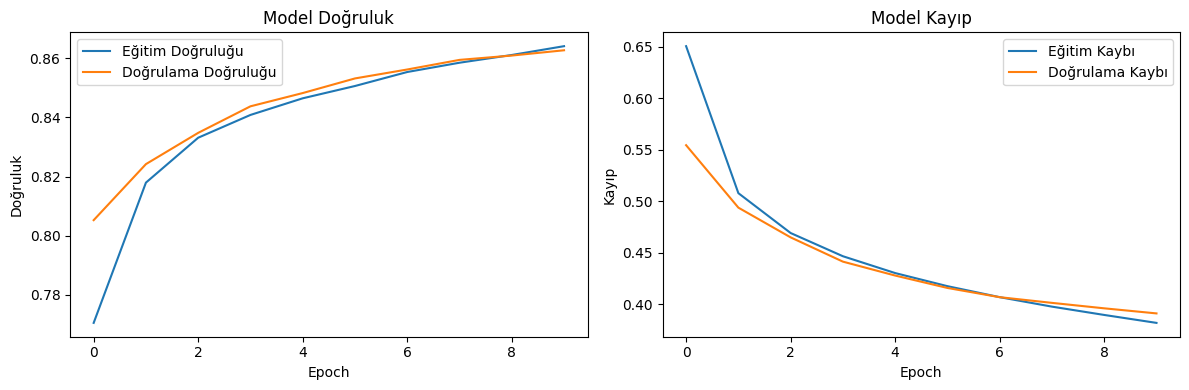

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluklarını çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Eğitim ve doğrulama kayıplarını çiz
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Test verisi üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Doğruluğu: {test_accuracy:.4f}")
print(f"Test Kaybı: {test_loss:.4f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.8678 - loss: 0.3754
Test Doğruluğu: 0.8573
Test Kaybı: 0.4024


171/171 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step
              precision    recall  f1-score   support

         CNV       0.85      0.93      0.89      3746
         DME       0.79      0.60      0.68      1161
      DRUSEN       0.60      0.30      0.40       887
      NORMAL       0.89      0.96      0.92      5139

    accuracy                           0.86     10933
   macro avg       0.78      0.70      0.72     10933
weighted avg       0.84      0.86      0.84     10933



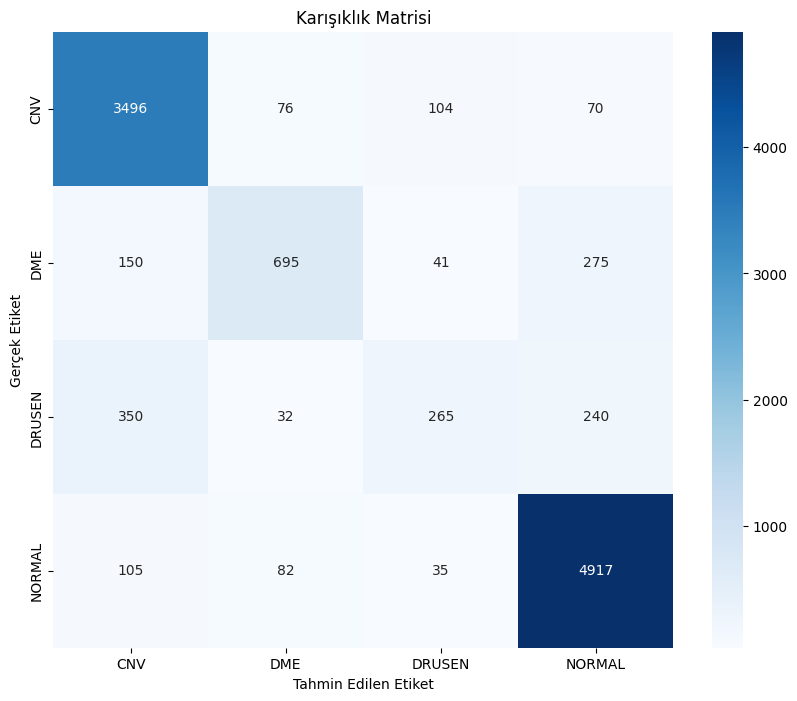

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf # Make sure tensorflow is imported for tf.data.Dataset

# Gerçek ve tahmin edilen sınıfları al
# Use the test_dataset directly with model.predict
Y_pred = model.predict(test_dataset)

# Since the labels are one-hot encoded (categorical), convert them back to class indices
y_pred = np.argmax(Y_pred, axis=1)

# To get the true labels from a tf.data.Dataset, you need to iterate over it.
# It's important to do this carefully to match the order of predictions.
# Assuming shuffle=False was used for the test_dataset, the order should match the directory listing order.
# However, the most robust way is to reconstruct the true labels based on the dataset structure.
# A simpler approach for classification report and confusion matrix with tf.data.Dataset
# is to get the ground truth labels when the dataset is loaded.
# We already have class_names from the load_datasets function.
# We can get the true labels by iterating through the test_dataset and extracting the labels.

# Extract true labels from the test_dataset
y_true = []
for images, labels in test_dataset.unbatch():
    # labels are one-hot encoded, so find the index of the true class
    y_true.append(np.argmax(labels.numpy()))

y_true = np.array(y_true)


# Sınıf adları already obtained from load_datasets function
# class_names is available from the previous cell.

# Sınıflandırma raporu
print(classification_report(y_true, y_pred, target_names=class_names))

# Karışıklık matrisi
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
# Use class_names for the tick labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karışıklık Matrisi')
plt.show()

In [ ]:
model.save("DenseNet.keras")


In [ ]:
from google.colab import files

# Keras modeli indirme
# Change the filename from "model.keras" to "DenseNet.keras"
files.download("DenseNet121.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>